$$\require{mhchem}$$
# Aerobic Degradation of a Generic Organic carbon

In this notebook, we model the reactions involved in the aerobic degradation of a generic organic carbon that would occur in a hypothetical controlled batch reaction setup.

In this setup we have the reactants at time t=0, at predefined concentrations and we measure the concentration evolution with time, considering a well mixed environment where reaction kinectics are the only limiting factor for the formation of products.


## 1. Chemical Setup

The model is simplified to two chemical reactions:

1. Energy metabolism:

$ \ce{CH_2O + O_2 -> CO_2 + H_2O} $
***
2. Anabolism (generation of biomass):

$ \ce{5CH_2O + NH_4^+ -> H^+ + C_5H_7O_2 + 3H_2O} $

We can see the organic carbon is consumed by both the oxidation and biomass production. Therefore the stoichiometry of the system must be evaluated according to the biomass efficiency:

Consider the molar mass of biomass: (113 g/mol). If we divide the second expression by the molar mass we get the stoichimetry of the reaction per gram of biomass:

Example: stoichimetry of $\ce{CH_2O}$

In [18]:
5/113

0.04424778761061947

2.1. Updated Stoichiometry of the biomass formation reaction:

$0.0442\ce{CH2O} + 0.0088 \ce{NH4+ ->} 0.0088 \ce{H+} + 0.0265 \ce{H2O} $

Now we need to consider the yield of the reaction (the amount of biomass generated by the consumption of the organic matter).

the Yield (**Y**) for this reaction will be:

In [19]:
Y = 17 # [g/molC_org]

$ Y = \frac{g_{biomass}}{C_{mol} consumed} = 1 g_{biomass}/(0.04424 + f)$

Where $f$ is the stoichiometry ratio of the energy metabolism part:

For this example we get:

In [20]:
f = 1/Y - 0.04424

In [21]:
f

0.014583529411764704

3. And the final reaction of the system:

$ (0.0442+0.0146) \ce{CH2O} + 0.0146\ce{O2} + 0.0088 \ce{NH4+ ->} 1gbio + 0.0088 \ce{H+} + 0.0146\ce{CO2} + (0.0265+0.0146)\ce{H2O} $

## 2. Mathematical Setup

The reactions involved here are kinetically controlled. We will use a Monod kinetic formulation for the representation of the reaction rates of the model

1. Microbial Growth Rate

$ r_X = r_{growth} + r_{decay} $

$ r_{growth} = \mu*X*\left(1-\frac{X}{X_{max}}\right) $

$ r_{decay} = - k_d*X$

$ \mu = \mu_{max}*\left(\frac{S_a}{S_a+K_a}\right)\left(\frac{S_d}{S_d+K_d}\right) $

2. Consumption of substrate and formation of products:

$ r_s = r_{growth}*\frac{1}{Y} $

$ r_O = r_{growth}*\frac{1}{Y_O} $

$ \frac{d\ce{[CH2O]}}{dt} = - r_s $

$ \frac{d\ce{[O2]}}{dt} = - r_O $

$ \frac{d\ce{[CO2]}}{dt} = r_O $



Where:

* $r_X$ is the microbial growth rate, accounting for Michaelis Mentem growth formulation ($\mu$) with additional limit constraint for the maximum fixated bacteria available. Bacterial decay is accounted for with a linear decay term ($k_d$)
* $\mu$ parameterises the growth rate accounting for the substrate electron acceptor  $Sa$ ($\ce{[O2]}$), and the $K_a$ parameter and electron donor $S_d$ ($\ce{[CH2O]}$) and $K_d$
* The rate of the reaction $r_s$ is controlled by the microbial growth rate and the substrate use efficiency $Y$. Since the stoichiometry under this condition is different, we also need to calculate a use efficiency for oxygen: $Y_O = 1/0.0146$ = 68.493

In [22]:
1/0.0146

68.4931506849315

## 3. Model

Now we can solve the model using a ODE solver. We use the `scipy` package solver `solve_ivp` 

In [23]:
# basic packages

import numpy as np
import matplotlib.pyplot as plt

### 3.1 Variables:

In [24]:
K_a = 1 #mM
K_d = 2 #mM
mu_max = 1.2 #mMhr^-1
X_max = 5 #
kd = 0.1*(1/(30*24))
Yo = 1/0.146

In [25]:
Y

17

In [26]:
X = 1 #arbitrary

### 3.2. Model

This is so python can find the src folder:

In [27]:
import sys
sys.path.append('../../')

importing the model:

In [28]:
from src.models.ch2o_oxidation import reactive_model

time variables:

In [29]:
#time-step of simulation:
dt = 1 #hr
## time-step arrays:
time = np.arange(0,24*15+dt,dt) # 30 days with time-steps every hour

initial concentrations:

In [30]:
# Assuming CO2 is in equilibrium at t = 0 with the atmosphere, we use Henry's Law to calculate its mass action:

Kh = 10**(-1.5)
PCO2 = 0.01
C_CO2 = Kh*PCO2*1000
C_CO2

0.31622776601683794

This is a upper boundary for the concentration of CO2, as the CO2 would react to form carbonic species ($\ce{HCO3-}$ etc). Another point is that CO2 is not limiting the reaction, which means that its concentrations is not so relevant for the consumption of CH2O

In [31]:
# And we do the same for O2:

KhO2 = 1/769.23
C_O2 = KhO2*0.21*1000
C_O2

0.27300027300027296

In [32]:
C_CH2O = 0.6

#### Solving the model:

In [33]:
sol = reactive_model(C_CH2O,C_O2,C_CO2,X,mu_max,K_d, K_a,X_max,kd,Y,Yo,(time[0],time[-1]),time)

#### Plotting the resulting concentrations:

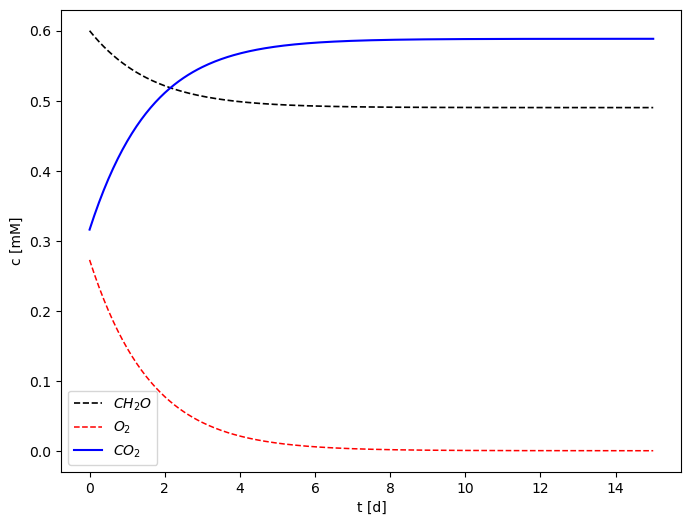

In [36]:
## plotting:
fig, ax = plt.subplots(figsize = (8,6))    
ax.plot(time/24,sol.y[0,:], '--k', lw = 1.2, label = '$CH_2O$')
ax.plot(time/24,sol.y[1,:], '--r', lw = 1.1, label = '$O_2$')
ax.plot(time/24,sol.y[2,:], '-b', lw = 1.5, label = '$CO_2$')
ax.legend()
ax.set_xlabel('t [d]')
ax.set_ylabel('c [mM]');

The system reaches equilibrium in about 8-10 days